# Machine Learning: Ridge Regression

Ridge regression is a regression technique that is quite similar to unadorned least squares linear regression: simply adding an $\ell_2$ **penalty** on the parameters $\beta$ to the objective function for linear regression yields the objective function for ridge regression.

Our goal is to find an assignment to $\beta$ that minimizes the function

$$f(\beta) = \|X\beta - Y\|_2^2 + \lambda \|\beta\|_2^2,$$

where $\lambda$ is a hyperparameter and, as usual, $X$ is the training data and $Y$ the observations. In practice, we tune $\lambda$ until we find a model that generalizes well to the test data.

Ridge regression is an example of a **shrinkage method**: compared to least squares, it shrinks the parameter estimates in the hopes of **reducing variance, improving prediction accuracy, and aiding interpetation**.

In this notebook, we show how to fit a ridge regression model using CVXPY, how to evaluate the model, and how to tune the hyper-parameter $\lambda$.


In [1]:
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt

### Writing the objective function

We can decompose the **objective function** as the sum of a **least squares loss function** and an $\ell_2$ **regularizer**.

In [2]:
def loss_fn(X, Y, beta):
    return cp.pnorm(X @ beta - Y, p=2)**2

def regularizer(beta):
    return cp.pnorm(beta, p=2)**2

def objective_fn(X, Y, beta, lambd):
    return loss_fn(X, Y, beta) + lambd * regularizer(beta)

def mse(X, Y, beta):
    return (1.0 / X.shape[0]) * loss_fn(X, Y, beta).value

### Generating data
Because ridge regression encourages the parameter estimates to be small, and as such tends to lead to models with **less variance** than those fit with vanilla linear regression. We generate a small dataset that will illustrate this.

In [3]:
def generate_data(m=100, n=20, sigma=5):
    "Generates data matrix X and observations Y."
    np.random.seed(1)
    beta_star = np.random.randn(n)
    # Generate an ill-conditioned data matrix
    X = np.random.randn(m, n)
    # Corrupt the observations with additive Gaussian noise
    Y = X.dot(beta_star) + np.random.normal(0, sigma, size=m)
    return X, Y

m = 100
n = 20
sigma = 1

X, Y = generate_data(m, n, sigma)
X_train = X[:50, :]
Y_train = Y[:50]
X_test = X[50:, :]
Y_test = Y[50:]

### Fitting the model

All we need to do to fit the model is create a CVXPY problem where the objective is to minimize the the objective function defined above. We make $\lambda$ a CVXPY parameter, so that we can use a single CVXPY problem to obtain estimates for many values of $\lambda$.

In [4]:
beta = cp.Variable(n)
lambd = cp.Parameter(nonneg=True)
problem = cp.Problem(cp.Minimize(objective_fn(X_train, Y_train, beta, lambd)))

lambd_values = np.logspace(-2, 3, 50)
train_errors = []
test_errors = []
beta_values = []
for v in lambd_values:
    lambd.value = v
    problem.solve()
    train_errors.append(mse(X_train, Y_train, beta))
    test_errors.append(mse(X_test, Y_test, beta))
    beta_values.append(beta.value)

### Evaluating the model

Notice that, up to a point, penalizing the size of the parameters reduces test error at the cost of increasing the training error, trading off higher bias for lower variance; in other words, this indicates that, for our example, a properly tuned ridge regression **generalizes better** than a least squares linear regression.

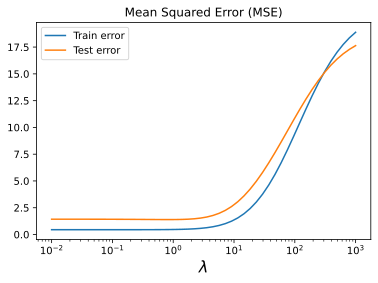

In [5]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

def plot_train_test_errors(train_errors, test_errors, lambd_values):
    plt.plot(lambd_values, train_errors, label="Train error")
    plt.plot(lambd_values, test_errors, label="Test error")
    plt.xscale("log")
    plt.legend(loc="upper left")
    plt.xlabel(r"$\lambda$", fontsize=16)
    plt.title("Mean Squared Error (MSE)")
    plt.show()
    
plot_train_test_errors(train_errors, test_errors, lambd_values)

### Regularization path
As expected, increasing $\lambda$ drives the parameters towards $0$. In a real-world example, those parameters that approach zero slower than others might correspond to the more **informative** features. It is in this sense that ridge regression can be considered **model selection.**

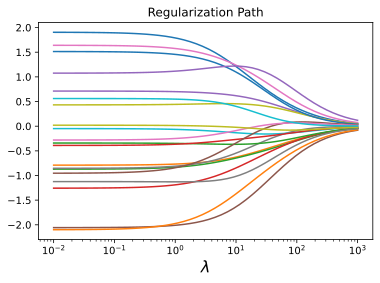

In [6]:
def plot_regularization_path(lambd_values, beta_values):
    num_coeffs = len(beta_values[0])
    for i in range(num_coeffs):
        plt.plot(lambd_values, [wi[i] for wi in beta_values])
    plt.xlabel(r"$\lambda$", fontsize=16)
    plt.xscale("log")
    plt.title("Regularization Path")
    plt.show()
    
plot_regularization_path(lambd_values, beta_values)

Implement in the CVXPY the solution of the following problem:

1. If $m \geq n$:

$$
\begin{split}
& \|X \beta - y\|_2^2 \to \min\limits_{\beta \in \mathbb{R}^n }\\
\text{s.t. } & \|\beta\|_2^2 \leq \lambda, \; X \in \mathbb{R}^{m \times n}, y \in \mathbb{R}^m
\end{split}
$$


2. If $m < n$:
$$
\begin{split}
& \|\beta\|_2^2 \to \min\limits_{\beta \in \mathbb{R}^n }\\
\text{s.t. } & X \beta = y, \; X \in \mathbb{R}^{m \times n}, y \in \mathbb{R}^m
\end{split}
$$

Compare the results with the solution of the unconstrained problem of Ridge regression.

<font color="lime"> ==YOUR ANSWER== </font>

# Machine Learning: Lasso Regression

Lasso regression is, like ridge regression, a **shrinkage** method. It differs from ridge regression in its choice of penalty: lasso imposes an $\ell_1$ **penalty** on the paramters $\beta$. That is, lasso finds an assignment to $\beta$ that minimizes the function

$$f(\beta) = \|X\beta - Y\|_2^2 + \lambda \|\beta\|_1,$$

where $\lambda$ is a hyperparameter and, as usual, $X$ is the training data and $Y$ the observations. The $\ell_1$ penalty encourages **sparsity** in the learned parameters, and, as we will see, can drive many coefficients to zero. In this sense, lasso is a continuous **feature selection** method.

In this notebook, we show how to fit a lasso model using CVXPY, how to evaluate the model, and how to tune the hyperparameter $\lambda$.


In [ ]:
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt

### Writing the objective function

We can decompose the **objective function** as the sum of a **least squares loss function** and an $\ell_1$ **regularizer**.

In [ ]:
def loss_fn(X, Y, beta):
    return cp.norm2(cp.matmul(X, beta) - Y)**2

def regularizer(beta):
    return cp.norm1(beta)

def objective_fn(X, Y, beta, lambd):
    return loss_fn(X, Y, beta) + lambd * regularizer(beta)

def mse(X, Y, beta):
    return (1.0 / X.shape[0]) * loss_fn(X, Y, beta).value

### Generating data
We generate training examples and observations that are linearly related; we make the relationship *sparse*, and we'll see how lasso will approximately recover it.

In [ ]:
def generate_data(m=100, n=20, sigma=5, density=0.2):
    "Generates data matrix X and observations Y."
    np.random.seed(1)
    beta_star = np.random.randn(n)
    idxs = np.random.choice(range(n), int((1-density)*n), replace=False)
    for idx in idxs:
        beta_star[idx] = 0
    X = np.random.randn(m,n)
    Y = X.dot(beta_star) + np.random.normal(0, sigma, size=m)
    return X, Y, beta_star

m = 100
n = 20
sigma = 5
density = 0.2

X, Y, _ = generate_data(m, n, sigma)
X_train = X[:50, :]
Y_train = Y[:50]
X_test = X[50:, :]
Y_test = Y[50:]

### Fitting the model

All we need to do to fit the model is create a CVXPY problem where the objective is to minimize the the objective function defined above. We make $\lambda$ a CVXPY parameter, so that we can use a single CVXPY problem to obtain estimates for many values of $\lambda$.

In [ ]:
beta = cp.Variable(n)
lambd = cp.Parameter(nonneg=True)
problem = cp.Problem(cp.Minimize(objective_fn(X_train, Y_train, beta, lambd)))

lambd_values = np.logspace(-2, 3, 50)
train_errors = []
test_errors = []
beta_values = []
for v in lambd_values:
    lambd.value = v
    problem.solve()
    train_errors.append(mse(X_train, Y_train, beta))
    test_errors.append(mse(X_test, Y_test, beta))
    beta_values.append(beta.value)

### Evaluating the model
Just as we saw for ridge regression, regularization improves generalizability.

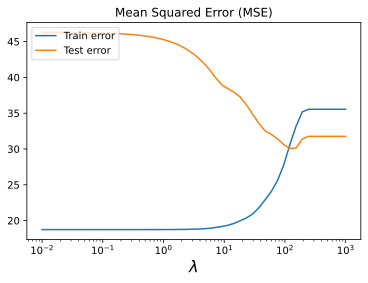

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

def plot_train_test_errors(train_errors, test_errors, lambd_values):
    plt.plot(lambd_values, train_errors, label="Train error")
    plt.plot(lambd_values, test_errors, label="Test error")
    plt.xscale("log")
    plt.legend(loc="upper left")
    plt.xlabel(r"$\lambda$", fontsize=16)
    plt.title("Mean Squared Error (MSE)")
    plt.show()
    
plot_train_test_errors(train_errors, test_errors, lambd_values)

### Regularization path and feature selection
As $\lambda$ increases, the parameters are driven to $0$. By $\lambda \approx 10$, approximately 80 percent of the coefficients are *exactly* zero. This parallels the fact that $\beta^*$ was generated such that 80 percent of its entries were zero. The features corresponding to the slowest decaying coefficients can be interpreted as the most important ones.

**Qualitatively, lasso differs from ridge in that the former often drives parameters to exactly zero, whereas the latter shrinks parameters but does not usually zero them out. That is, lasso results in sparse models; ridge (usually) does not.**

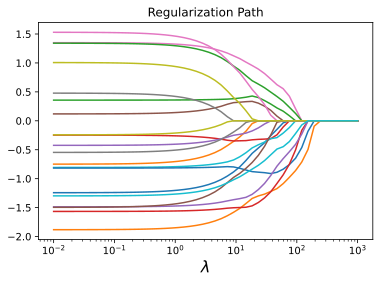

In [ ]:
def plot_regularization_path(lambd_values, beta_values):
    num_coeffs = len(beta_values[0])
    for i in range(num_coeffs):
        plt.plot(lambd_values, [wi[i] for wi in beta_values])
    plt.xlabel(r"$\lambda$", fontsize=16)
    plt.xscale("log")
    plt.title("Regularization Path")
    plt.show()
    
plot_regularization_path(lambd_values, beta_values)

Implement in the CVXPY the solution of the following problem:

1. If $m \geq n$:

$$
\begin{split}
& \|X \beta - y\|_2^2 \to \min\limits_{\beta \in \mathbb{R}^n }\\
\text{s.t. } & \|\beta\|_1 \leq \lambda, \; X \in \mathbb{R}^{m \times n}, y \in \mathbb{R}^m
\end{split}
$$


2. If $m < n$:
$$
\begin{split}
& \|\beta\|_1 \to \min\limits_{\beta \in \mathbb{R}^n }\\
\text{s.t. } & X \beta = y, \; X \in \mathbb{R}^{m \times n}, y \in \mathbb{R}^m
\end{split}
$$

Compare the results with the solution of the unconstrained problem of Lasso regression.

<font color="lime"> ==YOUR ANSWER== </font>

Modern [example](https://keras.io/examples/generative/wgan_gp/) of penalty method.